In [1]:
# https://platform.openai.com/docs/guides/vision
from openai import OpenAI
import base64
import requests
import os
from PIL import Image
from pillow_heif import register_heif_opener
import torch
from transformers.image_utils import ImageFeatureExtractionMixin

import open3d as o3d
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import RealSense as real

# Initialize RS435i connection
rsc = real.RealSense()
rsc.initConnection()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Import OWL-ViT
# from LANGrasp: https://huggingface.co/docs/transformers/model_doc/owlvit
from transformers import OwlViTProcessor, OwlViTForObjectDetection
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [3]:
# Helper Functions

# plot predictions
# https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb
SCORE_THRESHOLD = 0.01

def get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    pboxes = []
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      pboxes.append((pbox, text_queries[label]))
    return pboxes

def plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()
    
    idx = 0
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      print(pbox)
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]} ({idx}): {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })
      idx += 1

def encode_image(image_path):
    with open(f"{image_path}", "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
def displayWorld(worldPCD):
    coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    geometry = [coordFrame]
    geometry.append(worldPCD)
    o3d.visualization.draw_geometries(geometry)

In [4]:
def retrieve_mask_from_image_crop(box, full_o3d_image):
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])
    # y_min = int(box[0])
    # x_min = int(box[1])
    # y_max = int(box[2])
    # x_max = int(box[3])
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    bbox = x_min, y_min, x_max, y_max

    # mask out bounding box in img
    depth_image = np.asarray(full_o3d_image.depth)
    # depth_values = depth_image[x_min:x_max, y_min:y_max]
    depth_values = depth_image[y_min:y_max, x_min:x_max]
    depth_o3d = o3d.geometry.Image((depth_values).astype(np.uint8))
    rgb_image    = np.asarray(full_o3d_image.color)
    # rgb_values = np.asarray(rgbdImage.color)[x_min:x_max, y_min:y_max]
    rgb_values = np.asarray(full_o3d_image.color)[y_min:y_max, x_min:x_max]
    rgb_o3d = o3d.geometry.Image((rgb_values).astype(np.uint8))

    cropped_o3d_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, depth_o3d)

    # Also, assuming x_min, x_max, y_min, y_max define your region of interest (ROI)

    # Create masks for the region of interest
    roi_mask_rgb = np.zeros_like(rgb_image, dtype=bool)
    # roi_mask_rgb[x_min:x_max, y_min:y_max, :] = True
    roi_mask_rgb[y_min:y_max, x_min:x_max, :] = True

    roi_mask_depth = np.zeros_like(depth_image, dtype=bool)
    # roi_mask_depth[x_min:x_max, y_min:y_max] = True
    roi_mask_depth[y_min:y_max, x_min:x_max] = True

    rgb_m_array = rgb_image
    depth_m_array = depth_image
    # Apply the masks to set values outside the ROI to 0
    rgb_m_array[~roi_mask_rgb] = 255
    depth_m_array[~roi_mask_depth] = 0
    depth_m = o3d.geometry.Image((depth_m_array).astype(np.float32))
    rgb_m = o3d.geometry.Image((rgb_m_array).astype(np.uint8))
    
    rgbd_m_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_m, depth_m)
    
    return depth_m, rgb_m, rgbd_m_image

In [5]:
def crop_and_denoise_pcd(depth_m, orig_pcd):
    ###
    # This is the magic line
    # find the depth mask from the OWL ViT bounding box
    # reassign the orig rgbdImage
    # then recreate the pcd
    ###
    orig_pcd.depth = depth_m
    # et voila
    cpcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        orig_pcd,
        # rgbd_m_image,
        rsc.pinholeInstrinsics,
        project_valid_depth_only=True,
        extrinsic=rsc.extrinsics
    )

    # denoise pcd
    cl, ind = cpcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.01)
    inlier_cloud = cpcd.select_by_index(ind)
    # display_inlier_outlier(saved_pcd, ind)
    # displayWorld(inlier_cloud)

    mc = inlier_cloud.compute_mean_and_covariance()
    return inlier_cloud, mc

[504.8481559753418, 231.12975418567657, 681.8733406066895, 403.31863582134247]
[917.9485511779785, 395.67025780677795, 1202.1487998962402, 586.7213666439056]


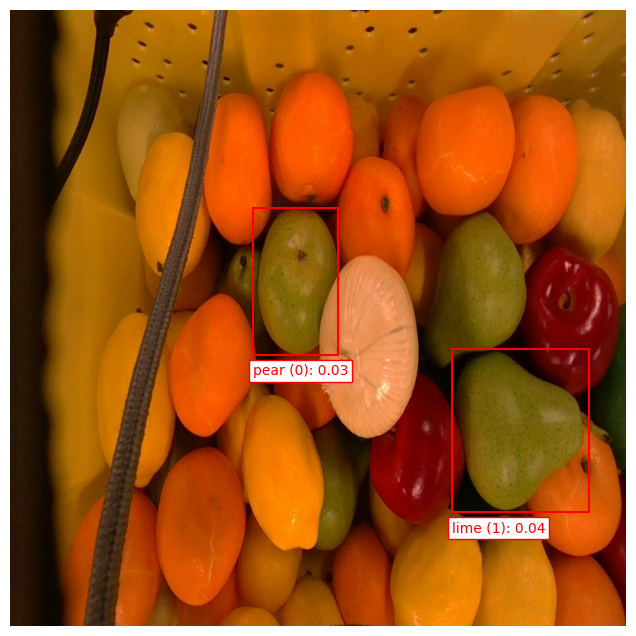

In [9]:
# take RealSense picture and run OWL-ViT inference
pcd,rgbdImage = rsc.getPCD()
img_tensor = torch.tensor(np.asarray(rgbdImage.color), dtype=torch.float32)
img = np.asarray(rgbdImage.color)

# run image through OWL-ViT
texts = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
# texts = [ "a photo of red cube", "a photo of a blue cube", "a photo of a yellow cube"]
# texts = ["apple", "lemon", "lime", "pear"]
inputs = processor(texts, images=img_tensor, padding=True, return_tensors="pt")
outputs = model(**inputs)
target_sizes = torch.Tensor([img.shape[:2][::-1]])

# Get prediction logits
def get_preds(outputs):
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()
    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    # boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    pboxes = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.01)[0]['boxes']
    return scores, labels, boxes, pboxes

scores, labels, boxes, pboxes = get_preds(outputs)
input_image = np.asarray(img).astype(np.float32) / 255.0
text_queries = ["apple", "lemon", "lime", "pear", "onion"]
# text_queries = ["r", "b", "y"]
# text_queries = ["apple", "lemon", "lime", "pear"]
THRESHOLD = 0.025
plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)
bboxes = get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)


In [10]:
pcd,rgbdImage = rsc.getPCD()
# index corresponds to (<num>) following label name of bounding boxes in above annotated image
index = 1
dm, rm, imgm = retrieve_mask_from_image_crop(bboxes[index][0], rgbdImage)
cpcd, mc = crop_and_denoise_pcd(dm, rgbdImage)
grasp_pose = [mc[0][1], -mc[0][0], mc[0][2]]
print(grasp_pose)
displayWorld(cpcd)

[0.05255757565063305, -0.1708789833105925, 0.25621697599090115]


In [9]:
import grab_test as gt
import rtde_control
import rtde_receive
from Motor_code import Motors
import UR5_Interface as ur5
import time
sleepRate = 0.75

try:
    robotIP = "192.168.0.6"
    con = rtde_control.RTDEControlInterface(robotIP)
    rec = rtde_receive.RTDEReceiveInterface(robotIP)
    servoPort = "/dev/ttyACM0"
    gripperController = Motors(servoPort)
    gripperController.torquelimit(600) # used to be 600
    gripperController.speedlimit(100)
    ur = ur5.UR5_Interface()
    ur.gripperController = gripperController
    try:
        ur.c = con
        ur.r = rec
        ur.gripperController = gripperController
    except Exception as e:
        raise(e)
    else:
        print("UR5 + Gripper Interface Established")
            
    # print(f"res: {projectToWorldCoords(res)} ")
    # ur.openGripper() # Open gripper
    # ur.testRoutine()
    homePose = ur.getPose()
    x_mod = 0.0
    y_mod = 0.0
    z_mod = 0.0
    #gt.moveToObj(grasp_pose, ur) 
    print("Done moving to obj")
    gt.grabStrat1(grasp_pose)
    #ur.closeGripper(9) 
    time.sleep(sleepRate)
    gt.moveBackFromObj(homePose, ur)
    ur.openGripper()
    gripperController.openGripper()
    gripperController.disconnect()
    ur.c.disconnect()
    ur.r.disconnect()
except Exception as e:
    gripperController.openGripper()
    gripperController.disconnect()
    ur.c.disconnect()
    ur.r.disconnect()
    raise(e)

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
UR5 + Gripper Interface Established
Done moving to obj
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
Successfully closed port


UnboundLocalError: local variable 'gripperController' referenced before assignment

In [15]:
servoPort = "/dev/ttyACM0"
gripperController = Motors(servoPort)


Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
